In [1]:
import numpy as np
import b18_routines as b18
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':'14'})
rc('text', usetex=False)

In [2]:
verbose = 1
%config Completer.use_jedi = False  #Speeds up tab autocomplete in notebooks

In [3]:
def MgO_core(X_C, XMgO_m, eps_C, logKd_MgO_B18, lngamma0a, lngamma0b, Tcmb, opt):

    cO_c_niM, cSi_c_niM, cMg_c_niM = np.zeros(len(Tcmb)), np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
    loggammaO, loggammaMg = np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
    
    params, min_conc = b18.min_conc_closure()
    
    XC_c   = X_C[0]
    XO_c   = X_C[1]
    XSi_c  = X_C[2]
    XS_c   = X_C[3] 
    XMgO_c = X_C[4]
    
    T0 = 1873.0
    verb = 0

    tt = 0
    for t in Tcmb: 
        eps = eps_C * T0 / t                                             # eqn S6
        lngamma0   = lngamma0a + lngamma0b/t
        lngamma0   = lngamma0  * (T0 / t)                                # eqn S5
        lngamma0[1]= lngamma0[1] * t/T0                                  # Do not set 
        lngammaFe  = b18.ln_gamma_Fe(X_C,eps,verb)                       # eqn S3
        lngammai   = b18.ln_gamma_i( X_C,eps, lngammaFe, lngamma0, verb) # eqn S4
    
        loggammaO[tt]  = lngammai[1]/2.303
        loggammaMg[tt] = lngammai[4]/2.303
    
        res = optimize.bisect(min_conc, 0, 0.1, args=(XO_c,XSi_c,XMgO_m,eps,lngamma0,logKd_MgO_B18[tt], t, opt))
    
        cO_c_niM[tt], cSi_c_niM[tt], cMg_c_niM[tt] = b18.mole2massconc_core(params['X'][1], params['X'][2], params['X'][4])

        if verbose == 1:
            print('T = {:6.1f} gammaC0 = {:6.4f} gamma_O0 = {:6.4f} gammaSi0 = {:6.4f} gammaS0 = {:6.4f} gammaMg0 = {:6.4f}'
                  .format(t,np.exp(lngamma0[0]),np.exp(lngamma0[1]),np.exp(lngamma0[2]), np.exp(lngamma0[3]), np.exp(lngamma0[4])))
            print('T = {:6.1f} gammaC  = {:6.4f} gamma_O  = {:6.4f} gammaSi  = {:6.4f} gammaS  = {:6.4f} gammaMg  = {:6.4f} gammaFe  = {:5.3f}'
              .format(t,np.exp(lngammai[0]),np.exp(lngammai[1]),np.exp(lngammai[2]), np.exp(lngammai[3]),np.exp(lngammai[4]), np.exp(lngammaFe)))
            print('T = {:6.1f} XMg = {:6.4f} XO = {:6.4f} cMg = {:6.4f}'.format(t, params['X'][4], params['X'][1], cMg_c_niM[tt]))
    
        tt = tt + 1
        
    return cO_c_niM, cSi_c_niM, cMg_c_niM, loggammaO, loggammaMg

In [4]:
# Set up input parameters that will be fixed throughout
a_B18_E, b_B18_E, c_B18_E = -1.98, -4402, 0.0 # Exchange

#2 sets of values for dissolution from '16 and '18 papers
a_Mg_B16, b_Mg_B16, c_Mg_B16 = 1.23, -18816.0, 0.0
a_Mg_B18, b_Mg_B18, c_Mg_B18 = 1.06  ,-12842 , 0.0 # Dissolution - use this for now. 

a_Mg_OS, b_Mg_OS, c_Mg_OS = 0.1,-10851,0.0
a_Si_OS, b_Si_OS, c_Si_OS = 1.3,-13500,0.0  # Fischer 2015
a_O_OS , b_O_OS , c_O_OS  = 0.6,-3800 ,22.0 # Fischer 2015

lngamma0a = np.array([-0.62,     4.29, -6.65, 0.0, 0.0])
lngamma0b = np.array([-0.00, -16500.0, 0.00 , 0.0, 0.0])

In [5]:
# These params may want to change...
Tcmb   = np.linspace(6000,2000,101)

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) #Mass fractions of core O,Si,MgO in mole fractions

XS_c = 0.0000
XC_c = 0.0000
XFe_c= 1-XO_c-XSi_c-XMgO_c
XMgO_m  = 0.5
XFeO_m  = 0.1
XSiO2_m = 1.0 -  XMgO_m - XFeO_m

X_C   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])

In [6]:
# Compare logKd values from different studies
logKd_MgO_B16 = b18.logKd_ideal(a_Mg_B16, b_Mg_B16, c_Mg_B16, Tcmb)
logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
logKd_MgO_O16 = b18.logKd_ideal(a_Mg_OS , b_Mg_OS , c_Mg_OS , Tcmb)
logKd_MgO_B18E= b18.logKd_ideal(a_B18_E , b_B18_E , c_B18_E , Tcmb)
logKd_MgO_D19_P8   = b18.D19_exchange(XO_c, XSi_c, Tcmb, P=8)
logKd_MgO_D19_P135 = b18.D19_exchange(XO_c, XSi_c, Tcmb, P=135)
logKd_MgO_D19_Fig3 = b18.D19_exchange(XO_c, XSi_c, Tcmb, P=135, b=-2900, c=16.0)

## Calculate activity coefficients ($\gamma$)

In [7]:
# Dissolution
eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0,-17.1, 3.6, 9.0, 4.9
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                = 24.3, -12.2, 4.4, 13.8

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) #Mass fractions of core O,Si,MgO in mole fractions

# eps needs to be a YxY symmetric matrix containing coeffs for C, O, Si, S, Mg, ...,. 
eps_C = np.array([[eps_CC , eps_OC , eps_CSi , eps_SC , eps_CMg], 
                  [eps_OC , eps_OO , eps_OSi , eps_OS , eps_OMg], 
                  [eps_CSi, eps_OSi, eps_SiSi, eps_SSi, eps_SiMg],
                  [eps_SC , eps_OS , eps_SSi , eps_SS , eps_SMg],
                  [eps_CMg, eps_OMg, eps_SiMg, eps_SMg, eps_MgMg]])

print('Input mole fractions [C, O, Si, S]: \n', X_C)
print('Input eps matrix: \n', eps_C)
cO_c_niM,cSi_c_niM,cMg_c_niM,loggammaO,loggammaMg = MgO_core(X_C,XMgO_m,eps_C,logKd_MgO_B18,lngamma0a,lngamma0b,Tcmb,1)

Input mole fractions [C, O, Si, S]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
Input eps matrix: 
 [[ 12.8 -20.    3.6   4.9  24.3]
 [-20.   -1.   -5.  -17.1 -12.2]
 [  3.6  -5.   12.4   9.    4.4]
 [  4.9 -17.1   9.   -5.7  13.8]
 [ 24.3 -12.2   4.4  13.8   0. ]]
T = 6000.0 gammaC0 = 0.8240 gamma_O0 = 4.6646 gammaSi0 = 0.1254 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 6000.0 gammaC  = 0.4728 gamma_O  = 4.1259 gammaSi  = 0.1326 gammaS  = 0.6900 gammaMg  = 0.7419 gammaFe  = 1.005
T = 6000.0 XMg = 0.0144 XO = 0.0950 cMg = 0.0114
T = 5960.0 gammaC0 = 0.8230 gamma_O0 = 4.5793 gammaSi0 = 0.1237 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5960.0 gammaC  = 0.4704 gamma_O  = 4.0471 gammaSi  = 0.1309 gammaS  = 0.6883 gammaMg  = 0.7404 gammaFe  = 1.005
T = 5960.0 XMg = 0.0142 XO = 0.0950 cMg = 0.0113
T = 5920.0 gammaC0 = 0.8219 gamma_O0 = 4.4944 gammaSi0 = 0.1220 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5920.0 gammaC  = 0.4680 gamma_O  = 3.9688 gammaSi  = 0.1291 gammaS  = 0.6865 gammaMg  = 

T = 4520.0 gammaC0 = 0.7734 gamma_O0 = 1.8956 gammaSi0 = 0.0636 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4520.0 gammaC  = 0.3699 gamma_O  = 1.6107 gammaSi  = 0.0685 gammaS  = 0.6110 gammaMg  = 0.6728 gammaFe  = 1.007
T = 4520.0 XMg = 0.0080 XO = 0.0950 cMg = 0.0063
T = 4480.0 gammaC0 = 0.7717 gamma_O0 = 1.8349 gammaSi0 = 0.0620 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4480.0 gammaC  = 0.3667 gamma_O  = 1.5568 gammaSi  = 0.0668 gammaS  = 0.6083 gammaMg  = 0.6704 gammaFe  = 1.007
T = 4480.0 XMg = 0.0078 XO = 0.0950 cMg = 0.0062
T = 4440.0 gammaC0 = 0.7699 gamma_O0 = 1.7750 gammaSi0 = 0.0605 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4440.0 gammaC  = 0.3634 gamma_O  = 1.5037 gammaSi  = 0.0652 gammaS  = 0.6056 gammaMg  = 0.6680 gammaFe  = 1.007
T = 4440.0 XMg = 0.0076 XO = 0.0950 cMg = 0.0060
T = 4400.0 gammaC0 = 0.7680 gamma_O0 = 1.7160 gammaSi0 = 0.0590 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4400.0 gammaC  = 0.3600 gamma_O  = 1.4516 gammaSi  = 0.0636 gammaS  = 0.6029 gammaMg  = 0.6656 gammaFe  =

T = 3200.0 gammaC0 = 0.6957 gamma_O0 = 0.4205 gammaSi0 = 0.0204 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3200.0 gammaC  = 0.2455 gamma_O  = 0.3341 gammaSi  = 0.0226 gammaS  = 0.4987 gammaMg  = 0.5713 gammaFe  = 1.009
T = 3200.0 XMg = 0.0030 XO = 0.0950 cMg = 0.0024
T = 3160.0 gammaC0 = 0.6925 gamma_O0 = 0.3940 gammaSi0 = 0.0194 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3160.0 gammaC  = 0.2411 gamma_O  = 0.3121 gammaSi  = 0.0216 gammaS  = 0.4943 gammaMg  = 0.5673 gammaFe  = 1.010
T = 3160.0 XMg = 0.0029 XO = 0.0950 cMg = 0.0023
T = 3120.0 gammaC0 = 0.6892 gamma_O0 = 0.3684 gammaSi0 = 0.0185 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3120.0 gammaC  = 0.2368 gamma_O  = 0.2910 gammaSi  = 0.0206 gammaS  = 0.4898 gammaMg  = 0.5632 gammaFe  = 1.010
T = 3120.0 XMg = 0.0027 XO = 0.0950 cMg = 0.0022
T = 3080.0 gammaC0 = 0.6859 gamma_O0 = 0.3440 gammaSi0 = 0.0175 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3080.0 gammaC  = 0.2324 gamma_O  = 0.2708 gammaSi  = 0.0195 gammaS  = 0.4853 gammaMg  = 0.5590 gammaFe  =

In [8]:
# Exchange
eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0,-17.1, 3.6, 9.0, 4.9
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                =  0.0, -18.2, 0.0, 0.0

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) 

X_CE   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])
eps_CE = np.array([[eps_CC , eps_OC , eps_CSi , eps_SC , eps_CMg], 
                  [eps_OC , eps_OO , eps_OSi , eps_OS , eps_OMg], 
                  [eps_CSi, eps_OSi, eps_SiSi, eps_SSi, eps_SiMg],
                  [eps_SC , eps_OS , eps_SSi , eps_SS , eps_SMg],
                  [eps_CMg, eps_OMg, eps_SiMg, eps_SMg, eps_MgMg]])

print('Input mole fractions [C, O, Si, S, Mg]: \n', X_CE)
print('Input eps matrix: \n', eps_CE)
print(XMgO_m)

cO_c_niE,cSi_c_niE,cMg_c_niE,loggammaOE,loggammaMgE = MgO_core(X_CE,XMgO_m,eps_CE,logKd_MgO_B18E,lngamma0a,lngamma0b,Tcmb,3)

Input mole fractions [C, O, Si, S, Mg]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
Input eps matrix: 
 [[ 12.8 -20.    3.6   4.9   0. ]
 [-20.   -1.   -5.  -17.1 -18.2]
 [  3.6  -5.   12.4   9.    0. ]
 [  4.9 -17.1   9.   -5.7   0. ]
 [  0.  -18.2   0.    0.    0. ]]
0.5
T = 6000.0 gammaC0 = 0.8240 gamma_O0 = 4.6646 gammaSi0 = 0.1254 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 6000.0 gammaC  = 0.4728 gamma_O  = 4.1259 gammaSi  = 0.1326 gammaS  = 0.6900 gammaMg  = 0.5699 gammaFe  = 1.005
T = 6000.0 XMg = 0.0144 XO = 0.0950 cMg = 0.0114
T = 5960.0 gammaC0 = 0.8230 gamma_O0 = 4.5793 gammaSi0 = 0.1237 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5960.0 gammaC  = 0.4704 gamma_O  = 4.0471 gammaSi  = 0.1309 gammaS  = 0.6883 gammaMg  = 0.5678 gammaFe  = 1.005
T = 5960.0 XMg = 0.0143 XO = 0.0950 cMg = 0.0113
T = 5920.0 gammaC0 = 0.8219 gamma_O0 = 4.4944 gammaSi0 = 0.1220 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5920.0 gammaC  = 0.4680 gamma_O  = 3.9688 gammaSi  = 0.1291 gammaS  = 0.6865 gam

T = 4760.0 gammaC0 = 0.7835 gamma_O0 = 2.2787 gammaSi0 = 0.0730 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4760.0 gammaC  = 0.3889 gamma_O  = 1.9521 gammaSi  = 0.0784 gammaS  = 0.6264 gammaMg  = 0.4923 gammaFe  = 1.006
T = 4760.0 XMg = 0.0108 XO = 0.0950 cMg = 0.0085
T = 4720.0 gammaC0 = 0.7819 gamma_O0 = 2.2128 gammaSi0 = 0.0714 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4720.0 gammaC  = 0.3858 gamma_O  = 1.8931 gammaSi  = 0.0767 gammaS  = 0.6239 gammaMg  = 0.4893 gammaFe  = 1.006
T = 4720.0 XMg = 0.0106 XO = 0.0950 cMg = 0.0084
T = 4680.0 gammaC0 = 0.7803 gamma_O0 = 2.1476 gammaSi0 = 0.0698 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4680.0 gammaC  = 0.3827 gamma_O  = 1.8350 gammaSi  = 0.0750 gammaS  = 0.6214 gammaMg  = 0.4864 gammaFe  = 1.006
T = 4680.0 XMg = 0.0105 XO = 0.0950 cMg = 0.0083
T = 4640.0 gammaC0 = 0.7786 gamma_O0 = 2.0833 gammaSi0 = 0.0683 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4640.0 gammaC  = 0.3796 gamma_O  = 1.7776 gammaSi  = 0.0734 gammaS  = 0.6189 gammaMg  = 0.4833 gammaFe  =

T = 3480.0 gammaC0 = 0.7163 gamma_O0 = 0.6367 gammaSi0 = 0.0279 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3480.0 gammaC  = 0.2748 gamma_O  = 0.5153 gammaSi  = 0.0307 gammaS  = 0.5274 gammaMg  = 0.3793 gammaFe  = 1.009
T = 3480.0 XMg = 0.0064 XO = 0.0950 cMg = 0.0051
T = 3440.0 gammaC0 = 0.7135 gamma_O0 = 0.6026 gammaSi0 = 0.0268 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3440.0 gammaC  = 0.2707 gamma_O  = 0.4865 gammaSi  = 0.0295 gammaS  = 0.5235 gammaMg  = 0.3751 gammaFe  = 1.009
T = 3440.0 XMg = 0.0063 XO = 0.0950 cMg = 0.0050
T = 3400.0 gammaC0 = 0.7107 gamma_O0 = 0.5695 gammaSi0 = 0.0256 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3400.0 gammaC  = 0.2666 gamma_O  = 0.4586 gammaSi  = 0.0283 gammaS  = 0.5195 gammaMg  = 0.3708 gammaFe  = 1.009
T = 3400.0 XMg = 0.0061 XO = 0.0950 cMg = 0.0049
T = 3360.0 gammaC0 = 0.7078 gamma_O0 = 0.5376 gammaSi0 = 0.0246 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3360.0 gammaC  = 0.2624 gamma_O  = 0.4318 gammaSi  = 0.0271 gammaS  = 0.5155 gammaMg  = 0.3664 gammaFe  =

T = 2120.0 gammaC0 = 0.5782 gamma_O0 = 0.0304 gammaSi0 = 0.0028 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2120.0 gammaC  = 0.1200 gamma_O  = 0.0215 gammaSi  = 0.0033 gammaS  = 0.3498 gammaMg  = 0.2037 gammaFe  = 1.014
T = 2120.0 XMg = 0.0019 XO = 0.0950 cMg = 0.0015
T = 2080.0 gammaC0 = 0.5722 gamma_O0 = 0.0262 gammaSi0 = 0.0025 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2080.0 gammaC  = 0.1152 gamma_O  = 0.0184 gammaSi  = 0.0029 gammaS  = 0.3428 gammaMg  = 0.1975 gammaFe  = 1.015
T = 2080.0 XMg = 0.0018 XO = 0.0950 cMg = 0.0014
T = 2040.0 gammaC0 = 0.5660 gamma_O0 = 0.0224 gammaSi0 = 0.0022 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2040.0 gammaC  = 0.1104 gamma_O  = 0.0156 gammaSi  = 0.0026 gammaS  = 0.3357 gammaMg  = 0.1913 gammaFe  = 1.015
T = 2040.0 XMg = 0.0016 XO = 0.0950 cMg = 0.0013
T = 2000.0 gammaC0 = 0.5595 gamma_O0 = 0.0191 gammaSi0 = 0.0020 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2000.0 gammaC  = 0.1057 gamma_O  = 0.0132 gammaSi  = 0.0023 gammaS  = 0.3285 gammaMg  = 0.1851 gammaFe  =

In [9]:
# Dissociation
a_Mg_B18_D, b_Mg_B18_D, c_Mg_B18_D = 0.1, -14054.0, 0.0
logKd_MgO_B18D = b18.logKd_ideal(a_Mg_B18_D, b_Mg_B18_D, c_Mg_B18_D, Tcmb)

eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0,-17.1, 3.6, 9.0, 4.9
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                = 25.0, -23.1, 6.5, 13.1

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) 

X_CD   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])
eps_CD = np.array([[eps_CC , eps_OC , eps_CSi , eps_SC , eps_CMg], 
                  [eps_OC , eps_OO , eps_OSi , eps_OS , eps_OMg], 
                  [eps_CSi, eps_OSi, eps_SiSi, eps_SSi, eps_SiMg],
                  [eps_SC , eps_OS , eps_SSi , eps_SS , eps_SMg],
                  [eps_CMg, eps_OMg, eps_SiMg, eps_SMg, eps_MgMg]])

print('Input mole fractions [C, O, Si, S, Mg]: \n', X_CD)
print('Input eps matrix: \n', eps_CD)
print(XMgO_m)

cO_c_niD,cSi_c_niD,cMg_c_niD,loggammaOD,loggammaMgD = MgO_core(X_CD,XMgO_m,eps_CD,logKd_MgO_B18D,lngamma0a,lngamma0b,Tcmb,2)

Input mole fractions [C, O, Si, S, Mg]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
Input eps matrix: 
 [[ 12.8 -20.    3.6   4.9  25. ]
 [-20.   -1.   -5.  -17.1 -23.1]
 [  3.6  -5.   12.4   9.    6.5]
 [  4.9 -17.1   9.   -5.7  13.1]
 [ 25.  -23.1   6.5  13.1   0. ]]
0.5
T = 6000.0 gammaC0 = 0.8240 gamma_O0 = 4.6646 gammaSi0 = 0.1254 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 6000.0 gammaC  = 0.4728 gamma_O  = 4.1259 gammaSi  = 0.1326 gammaS  = 0.6900 gammaMg  = 0.5479 gammaFe  = 1.005
T = 6000.0 XMg = 0.0149 XO = 0.0950 cMg = 0.0118
T = 5960.0 gammaC0 = 0.8230 gamma_O0 = 4.5793 gammaSi0 = 0.1237 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5960.0 gammaC  = 0.4704 gamma_O  = 4.0471 gammaSi  = 0.1309 gammaS  = 0.6883 gammaMg  = 0.5457 gammaFe  = 1.005
T = 5960.0 XMg = 0.0147 XO = 0.0950 cMg = 0.0116
T = 5920.0 gammaC0 = 0.8219 gamma_O0 = 4.4944 gammaSi0 = 0.1220 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5920.0 gammaC  = 0.4680 gamma_O  = 3.9688 gammaSi  = 0.1291 gammaS  = 0.6865 gam

T = 4760.0 gammaC0 = 0.7835 gamma_O0 = 2.2787 gammaSi0 = 0.0730 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4760.0 gammaC  = 0.3889 gamma_O  = 1.9521 gammaSi  = 0.0784 gammaS  = 0.6264 gammaMg  = 0.4684 gammaFe  = 1.006
T = 4760.0 XMg = 0.0088 XO = 0.0950 cMg = 0.0069
T = 4720.0 gammaC0 = 0.7819 gamma_O0 = 2.2128 gammaSi0 = 0.0714 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4720.0 gammaC  = 0.3858 gamma_O  = 1.8931 gammaSi  = 0.0767 gammaS  = 0.6239 gammaMg  = 0.4654 gammaFe  = 1.006
T = 4720.0 XMg = 0.0086 XO = 0.0950 cMg = 0.0068
T = 4680.0 gammaC0 = 0.7803 gamma_O0 = 2.1476 gammaSi0 = 0.0698 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4680.0 gammaC  = 0.3827 gamma_O  = 1.8350 gammaSi  = 0.0750 gammaS  = 0.6214 gammaMg  = 0.4624 gammaFe  = 1.006
T = 4680.0 XMg = 0.0084 XO = 0.0950 cMg = 0.0066
T = 4640.0 gammaC0 = 0.7786 gamma_O0 = 2.0833 gammaSi0 = 0.0683 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4640.0 gammaC  = 0.3796 gamma_O  = 1.7776 gammaSi  = 0.0734 gammaS  = 0.6189 gammaMg  = 0.4593 gammaFe  =

T = 3480.0 gammaC0 = 0.7163 gamma_O0 = 0.6367 gammaSi0 = 0.0279 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3480.0 gammaC  = 0.2748 gamma_O  = 0.5153 gammaSi  = 0.0307 gammaS  = 0.5274 gammaMg  = 0.3544 gammaFe  = 1.009
T = 3480.0 XMg = 0.0035 XO = 0.0950 cMg = 0.0027
T = 3440.0 gammaC0 = 0.7135 gamma_O0 = 0.6026 gammaSi0 = 0.0268 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3440.0 gammaC  = 0.2707 gamma_O  = 0.4865 gammaSi  = 0.0295 gammaS  = 0.5235 gammaMg  = 0.3501 gammaFe  = 1.009
T = 3440.0 XMg = 0.0033 XO = 0.0950 cMg = 0.0026
T = 3400.0 gammaC0 = 0.7107 gamma_O0 = 0.5695 gammaSi0 = 0.0256 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3400.0 gammaC  = 0.2666 gamma_O  = 0.4586 gammaSi  = 0.0283 gammaS  = 0.5195 gammaMg  = 0.3458 gammaFe  = 1.009
T = 3400.0 XMg = 0.0032 XO = 0.0950 cMg = 0.0025
T = 3360.0 gammaC0 = 0.7078 gamma_O0 = 0.5376 gammaSi0 = 0.0246 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 3360.0 gammaC  = 0.2624 gamma_O  = 0.4318 gammaSi  = 0.0271 gammaS  = 0.5155 gammaMg  = 0.3415 gammaFe  =

T = 2240.0 gammaC0 = 0.5955 gamma_O0 = 0.0461 gammaSi0 = 0.0038 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2240.0 gammaC  = 0.1344 gamma_O  = 0.0332 gammaSi  = 0.0045 gammaS  = 0.3701 gammaMg  = 0.1996 gammaFe  = 1.014
T = 2240.0 XMg = 0.0005 XO = 0.0950 cMg = 0.0004
T = 2200.0 gammaC0 = 0.5899 gamma_O0 = 0.0404 gammaSi0 = 0.0035 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2200.0 gammaC  = 0.1296 gamma_O  = 0.0289 gammaSi  = 0.0040 gammaS  = 0.3635 gammaMg  = 0.1938 gammaFe  = 1.014
T = 2200.0 XMg = 0.0005 XO = 0.0950 cMg = 0.0004
T = 2160.0 gammaC0 = 0.5841 gamma_O0 = 0.0351 gammaSi0 = 0.0031 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2160.0 gammaC  = 0.1248 gamma_O  = 0.0250 gammaSi  = 0.0037 gammaS  = 0.3567 gammaMg  = 0.1880 gammaFe  = 1.014
T = 2160.0 XMg = 0.0004 XO = 0.0950 cMg = 0.0003
T = 2120.0 gammaC0 = 0.5782 gamma_O0 = 0.0304 gammaSi0 = 0.0028 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2120.0 gammaC  = 0.1200 gamma_O  = 0.0215 gammaSi  = 0.0033 gammaS  = 0.3498 gammaMg  = 0.1822 gammaFe  =

Note that Figure 6 plots from Fischer 2016 are plotted in the background above

In [10]:
# OS16 and D19 consider exchange
XMg_O16_E  = b18.Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_O16_E, cSi_c_O16_E, cMg_c_O16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_E)

XMg_D19_E_P8    = XFe_c * XMgO_m * 10**(b18.D19_exchange(XO_c, XSi_c, Tcmb, P=8  )) / XFeO_m
cO_c_D19_E_P8, cSi_c_D19_E_P8, cMg_c_D19_E_P8 = b18.mole2massconc_core(XO_c, XSi_c, XMg_D19_E_P8)
XMg_D19_E_P135  = XFe_c * XMgO_m * 10**(b18.D19_exchange(XO_c, XSi_c, Tcmb, P=135)) / XFeO_m
cO_c_D19_E_P135, cSi_c_D19_E_P135, cMg_c_D19_E_P135 = b18.mole2massconc_core(XO_c, XSi_c, XMg_D19_E_P135)
XMg_D19_E_Fig3  = XFe_c * XMgO_m * 10**(b18.D19_exchange(XO_c, XSi_c, Tcmb, P=135, b=-2900, c=16.0)) / XFeO_m
cO_c_D19_E_Fig3, cSi_c_D19_E_Fig3, cMg_c_D19_E_Fig3 = b18.mole2massconc_core(XO_c, XSi_c, XMg_D19_E_Fig3)

# B18 show that dissociation and dissolution are similar so just do the latter. 
XMg_B16_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B16, 0.0, 0.0)
XMg_B18_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18, 0.0, 0.0)
XMg_O16_DLi = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_B16_DLi, cSi_c_B16_DLi, cMg_c_B16_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_DLi)
cO_c_B18_DLi, cSi_c_B18_DLi, cMg_c_B18_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_DLi)
cO_c_O16_DLi, cSi_c_O16_DLi, cMg_c_O16_DLi = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_DLi)

XMg_B18_DLni  = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,loggammaMg)
XO_c_ni       = XMg_B18_DLni + XO_c                                         # Add O in MgO to core O 
cO_c_B18_DLni, cSi_c_B18_DLni, cMg_c_B18_DLni = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLni)

XMg_B18_DLniMg = b18.Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,0.0)
XO_c_niMg      =  XMg_B18_DLniMg + XO_c                                        # Add O in MgO to core O 
cO_c_B18_DLniMg, cSi_c_B18_DLniMg, cMg_c_B18_DLniMg = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLniMg)

# B16 dissolution reaction
XMg_B16 = b18.Mg_dissolution_B16(XMgO_m, 10**logKd_MgO_B16)
cO_c_B16, cSi_c_B16, cMg_c_B16 = b18.mole2massconc_core(0.0, 0.0, XMg_B16)

print('Tcmb        = ', Tcmb[0])
print('\nInput mole fractions:')
display(Math(r'X_O^{{metal}} = {}\\ X_{{Si}}^{{metal}} = {}\\ X_{{MgO}}^{{metal}} = {}\\ X_{{FeO}}^{{metal}} = {}'.format(XO_c, XSi_c, XMgO_c, XFe_c)))

display(Math(r'X_{{MgO}}^{{silicate}} = {}\\'.format(XMgO_m)))
print('a + b/T     = ', logKd_MgO_B18[0])
print('log_gammaO  = ', loggammaO[0])
print('log_gammaMg = ', loggammaMg[0])
display(Math(r'X_{{MgO}}^{{metal}} = {}'.format(XMg_B18_DLni[0])))
print('Which should be the same as:')
print(10**(a_Mg_B18 + b_Mg_B18/Tcmb[0] + np.log10(XMgO_m) - loggammaO[0] - loggammaMg[0]))

Tcmb        =  6000.0

Input mole fractions:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

a + b/T     =  -1.0803333333333334
log_gammaO  =  0.6154065827354627
log_gammaMg =  -0.12963563822565738


<IPython.core.display.Math object>

Which should be the same as:
0.013578935533439326


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


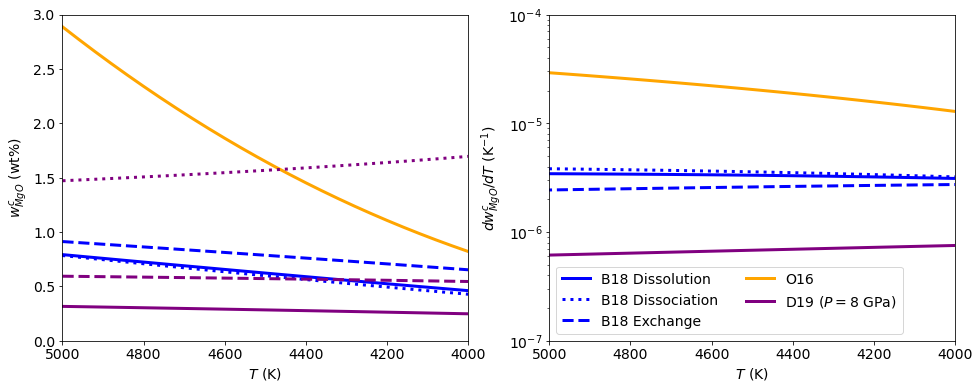

In [11]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(16,6))

badro_4a = plt.imread('badro_18_fig4a.png')
#ax2.imshow(badro_4a, extent=(4000,5000,0,1.5), aspect='auto')

ax2.set_xlim([5000,4000])
ax2.set_ylim([0   ,3.0   ])
ax2.set_xlabel("$T$ (K)")
ax2.set_ylabel("$w_{MgO}^{c}$ (wt%)")
#ax2.plot(Tcmb, cMg_c_B18_DLi*100   , label="B18 $\gamma_i=0$"                     , color='red', lw=3)
#ax2.plot(Tcmb, cMg_c_B18_DLniMg*100, label="B18 $\gamma_O\\ne0 \gamma_{Mg}=0$ "   , color='red',linestyle='--', lw=3)
ax2.plot(Tcmb, cMg_c_niM*100     , label="B18 Dissolution" , lw=3, color="blue", linestyle='-')
ax2.plot(Tcmb, cMg_c_niD*100     , label="B18 Dissociation", lw=3, color="blue", linestyle=':')
ax2.plot(Tcmb, cMg_c_niE*100     , label="B18 Exchange"    , lw=3, color="blue", linestyle='--')
ax2.plot(Tcmb, cMg_c_O16_E*100   , label="O16", color='orange', lw=3)
ax2.plot(Tcmb, cMg_c_D19_E_P8  *100   , label="D19 ($P=8$ GPa)"  , color='purple', lw=3, linestyle='-')
ax2.plot(Tcmb, cMg_c_D19_E_P135*100   , label="D19 ($P=135$ GPa)", color='purple', lw=3, linestyle=':')
ax2.plot(Tcmb, cMg_c_D19_E_Fig3*100   , label="D19 (Fig3)"       , color='purple', lw=3, linestyle='--')
#ax2.legend(ncol=2)

dT = Tcmb[1] - Tcmb[0]
dcMgdT_DLi    = np.gradient(cMg_c_B18_DLi   , dT)
dcMgdT_DLni   = np.gradient(cMg_c_B18_DLni  , dT)
dcMgdT_DLniMg = np.gradient(cMg_c_B18_DLniMg, dT)
dcMgdT_niM    = np.gradient(cMg_c_niM       , dT)
dcMgdT_niD    = np.gradient(cMg_c_niD       , dT)
dcMgdT_niE    = np.gradient(cMg_c_niE       , dT)
dcMgdT_O16E   = np.gradient(cMg_c_O16_E     , dT)
dcMgdT_D19E_P8   = np.gradient(cMg_c_D19_E_P8  , dT)
dcMgdT_D19E_P135 = np.gradient(cMg_c_D19_E_P135, dT)

ax3.set_xlim([5000,4000])
ax3.set_ylim([1e-7,1e-4])
ax3.set_yscale('log')
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$d w_{MgO}^c/dT$ (K$^{-1}$)")
ax3.plot(Tcmb, dcMgdT_niM    , label="B18 Dissolution" , lw=3, color="blue", linestyle='-')
ax3.plot(Tcmb, dcMgdT_niD    , label="B18 Dissociation", lw=3, color="blue", linestyle=':')
ax3.plot(Tcmb, dcMgdT_niE    , label="B18 Exchange"    , lw=3, color="blue", linestyle='--')
ax3.plot(Tcmb, dcMgdT_O16E   , label="O16"             , lw=3, color="orange")
ax3.plot(Tcmb, dcMgdT_D19E_P8, label="D19 ($P=8$ GPa)" , lw=3, color="purple")
ax3.legend(ncol=2)
fig.savefig("reactions.pdf", format='pdf',bbox_inches="tight")

Loop over compositions to get dc/dT

Mole fractions 0.03381642512077295 0.019323671497584544 0.0
Mole fractions 0.03225806451612904 0.11059907834101385 0.0
Mole fractions 0.0967741935483871 0.018433179723502304 0.0
Mole fractions 0.09251101321585904 0.10572687224669605 0.0
Mole fractions 0.1810344827586207 0.01724137931034483 0.0
Mole fractions 0.1735537190082645 0.09917355371900828 0.0


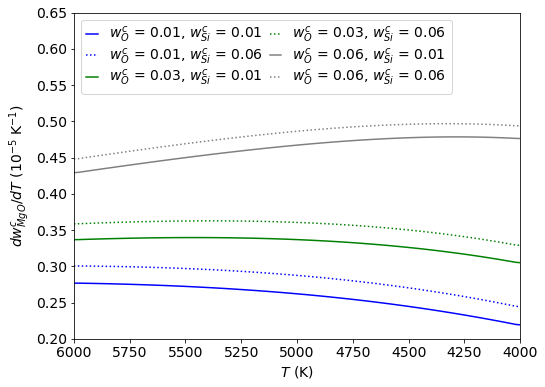

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
verbose = 2

Tcmb2 = np.linspace(6000,4000,101)
dT2   = Tcmb2[1] - Tcmb2[0]
logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb2)

# NOTE THESE ARE MASS FRACTIONS!!
XS_c  = 0.0000
XC_c  = 0.0000
XMgO_m= 0.5
XO_array  = [0.01, 0.03, 0.06]
XSi_array = [0.01, 0.06]

ls = ["-", ":"] 
lc = ["blue", "green", "grey"] 

for XOi, XO in enumerate(XO_array):
    for XSii, XSi in enumerate(XSi_array):

        core_mass_fractions = [XO, XSi, 0]
        XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions)
        X_C   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])
        
        print('Mole fractions', XO_c, XSi_c, XMgO_c)

        cO_c_cvar,cSi_c_cvar,cMg_c_cvar,tmp,tmp = MgO_core(X_C,XMgO_m,eps_C,logKd_MgO_B18,lngamma0a,lngamma0b,Tcmb2,1)
        
        dcMgdT_cvar = np.gradient(cMg_c_cvar, dT2)
        ax.plot(Tcmb2, dcMgdT_cvar*1e5, label="$w_O^c$ = "+str(XO)+", $w_{Si}^c$ = "+str(XSi), color=lc[XOi], linestyle=ls[XSii])
    
ax.legend(ncol=2,labelspacing=0.1,handlelength=0.8, columnspacing=0.5, loc="upper left")
ax.set_xlim([6000,4000])
ax.set_ylim([0.2,0.65])
ax.set_xlabel("$T$ (K)")
ax.set_ylabel("$d w_{MgO}^c/dT$ ($10^{-5}$ K$^{-1}$)")
fig.savefig("coreconcvar.pdf", format='pdf',bbox_inches="tight")

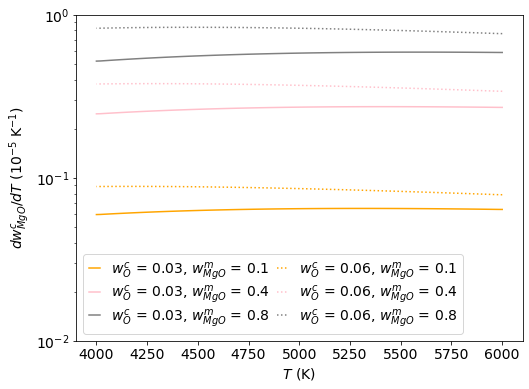

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
verbose = 2

Tcmb2 = np.linspace(6000,4000,101)
dT2   = Tcmb2[1] - Tcmb2[0]
logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb2)

XS_c  = 0.0000
XC_c  = 0.0000
XSi   = 0.03
XO_array  = [0.03, 0.06]
XMgOm_array = [0.1, 0.4, 0.8]

ls = ["-", ":"] 
lc = ["orange", "pink", "grey"] 

for XOi, XO in enumerate(XO_array):
    for XMgOmi, XMgOm in enumerate(XMgOm_array):

        core_mass_fractions = [XO, XSi, 0]
        XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions)
        X_C   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])

        cO_c_cvar,cSi_c_cvar,cMg_c_cvar,tmp,tmp = MgO_core(X_C,XMgOm,eps_C,logKd_MgO_B18,lngamma0a,lngamma0b,Tcmb2,1)
    
        dcMgdT_cvar = np.gradient(cMg_c_cvar, dT2)
        ax.plot(Tcmb2, dcMgdT_cvar*1e5, label="$w_O^c$ = "+str(XO)+", $w_{MgO}^m$ = "+str(XMgOm), 
                color=lc[XMgOmi], linestyle=ls[XOi])
    
ax.legend(ncol=2, labelspacing=0.1,handlelength=0.8, columnspacing=0.5)
ax.set_yscale('log')
ax.set_ylim([1e-2,1e0])
ax.set_xlabel("$T$ (K)")
ax.set_ylabel("$d w_{MgO}^c/dT$ ($10^{-5}$ K$^{-1}$)")

fig.savefig("mantleconc.pdf", format='pdf',bbox_inches="tight")

In [14]:
import pandas as pd
names = ["Reference", "Experiment","P","T","T_uncert","Fe", "Si","O","C","S","Mg","FeO","SiO2","MgO","Al01"]

df = pd.read_excel("grl58362-sup-0002-2018gl080405-ds01.xlsx", names=names, 
                   skiprows=3, usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16))

NaNs = np.isnan(df['Si'])
df['Si'][NaNs] = 1e-5
NaNs = np.isnan(df['C'])
df['C'][NaNs] = 1e-5
NaNs = np.isnan(df['S'])
df['S'][NaNs] = 1e-5

<ipython-input-14-ee43d8cff7d9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Si'][NaNs] = 1e-5
<ipython-input-14-ee43d8cff7d9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['C'][NaNs] = 1e-5
<ipython-input-14-ee43d8cff7d9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['S'][NaNs] = 1e-5


In [15]:
Kd_dl = df['Mg']/df['MgO']
logKd_dl_ideal = np.log10(Kd_dl)
Kd_ds = df['Mg']/df['MgO']  * df['O']
logKd_ds_ideal = np.log10(Kd_ds)
Kd_e  = df['Mg']*df['FeO']/(df['MgO']*df['Fe'])
logKd_e_ideal  = np.log10(Kd_e)

fit_dl_ideal = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
fit_dl       = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb) - loggammaO - loggammaMg
fit_ds_ideal = b18.logKd_ideal(a_Mg_B18_D, b_Mg_B18_D, c_Mg_B18_D, Tcmb)
fit_ds       = b18.logKd_ideal(a_Mg_B18_D, b_Mg_B18_D, c_Mg_B18_D, Tcmb) - loggammaOD - loggammaMgD
fit_e_ideal  = b18.logKd_ideal(a_B18_E, b_B18_E, c_B18_E, Tcmb)

logKd_dl_ni, logKd_ds_ni, logKd_e_ni = np.zeros(len(df['T'])), np.zeros(len(df['T'])), np.zeros(len(df['T']))

i = 0 
for t in df['T']:
    
    X_b18   = np.array( [df['C'][i], df['O'][i], df['Si'][i], df['S'][i], df['Mg'][i]] )
    
    eps_dl     = eps_C  * 1873.0 / t
    eps_ds     = eps_CD * 1873.0 / t 
    eps_e      = eps_CE * 1873.0 / t 
    lngamma0   = lngamma0a + lngamma0b/t
    lngamma0   = lngamma0  * (1873.0 / t)
    lngamma0[1]= lngamma0[1] * t/1873.0       
    
    # Eqn 4
    lngammaFe      = b18.ln_gamma_Fe(X_b18,eps_dl,2)   
    lngammai       = b18.ln_gamma_i( X_b18,eps_dl, lngammaFe, lngamma0, 2)
    logKd_dl_ni[i] = np.log10( (df['Mg'][i]/df['MgO'][i]) )             + lngammai[1]/2.303 + lngammai[4]/2.303
        
    # Eqn 5
    lngammaFe      = b18.ln_gamma_Fe(X_b18,eps_ds,2)   
    lngammai       = b18.ln_gamma_i( X_b18,eps_ds, lngammaFe, lngamma0, 2)    
    logKd_ds_ni[i] = np.log10( (df['Mg'][i]*df['O'][i]/df['MgO'][i]) )  + lngammai[1]/2.303 + lngammai[4]/2.303

    # Eqn 6
    lngammaFe      = b18.ln_gamma_Fe(X_b18,eps_e,2)   
    lngammai       = b18.ln_gamma_i( X_b18,eps_e,  lngammaFe, lngamma0, 3)    
    logKd_e_ni[i]  = np.log10( df['Mg'][i]*df['FeO'][i]/(df['MgO'][i]*df['Fe'][i]) ) + lngammai[4]/2.303 - lngammaFe/2.303
    
    i = i + 1
    

In [16]:
# fit ideal exchange data
def fit_exchange(T, a, b):
    return a + b/T

res = optimize.curve_fit(fit_exchange, df['T'], logKd_e_ideal )
print('Exchange: ', res[0])
myfit_ex_ideal = res[0][0] + res[0][1]/Tcmb

res = optimize.curve_fit(fit_exchange, df['T'], logKd_ds_ideal )
print('Dissociation: ', res[0])
myfit_ds_ideal = res[0][0] + res[0][1]/Tcmb

res = optimize.curve_fit(fit_exchange, df['T'], logKd_dl_ideal )
print('Dissolution: ', res[0])
myfit_dl_ideal = res[0][0] + res[0][1]/Tcmb

Exchange:  [-1.44827845e+00 -3.59603930e+03]
Dissociation:  [-1.03926995e+00 -6.15101025e+03]
Dissolution:  [-4.54628131e-01 -5.21099374e+03]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


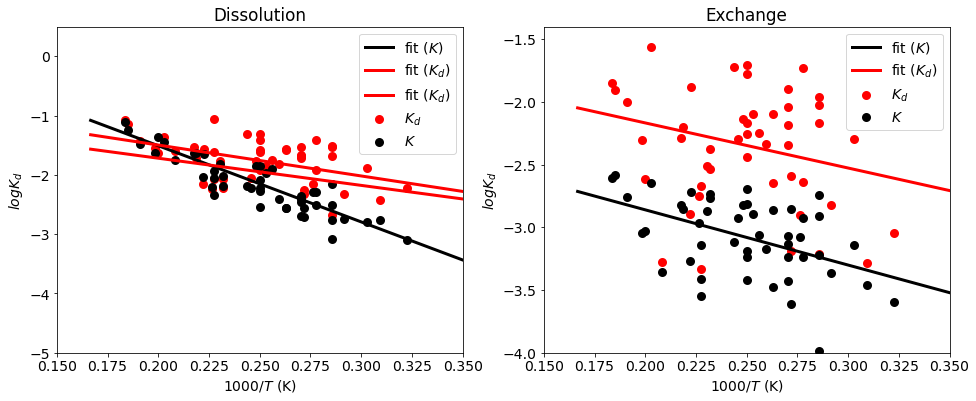

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

#badro_1a = plt.imread('badro_18_fig1a.png')
#ax1.imshow(badro_1a, extent=(0.15,0.35,-3.5,-0.5), aspect='auto')

#badro_1a = plt.imread('badro_18_fig1a.png')
#ax1.imshow(badro_1a, extent=(0.15,0.35,-3.5,-0.5), aspect='auto')

ax1.set_xlim([0.15,0.35])
ax1.set_ylim([-5,0.5]) # Fischer Fig 6
ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$log K_d$")
ax1.set_xlim([0.15,0.35])
ax1.set_title("Dissolution")
ax1.scatter(1000.0/df['T'], logKd_dl_ideal , lw=3, color="red"  , label="$K_d$")
ax1.scatter(1000.0/df['T'], logKd_dl_ni    , lw=3, color="black", label="$K$")
ax1.plot(1000.0/Tcmb, fit_dl_ideal  , lw=3, color="black", label="fit ($K$)")
ax1.plot(1000.0/Tcmb, fit_dl        , lw=3, color="red"  , label="fit ($K_d$)")
ax1.plot(1000.0/Tcmb, myfit_dl_ideal, lw=3, color="red"  , label="fit ($K_d$)")
ax1.legend()

ax2.set_xlim([0.15,0.35])
ax2.set_ylim([-4,-1.4]) # Fischer Fig 6
ax2.set_xlabel("$1000/T$ (K)")
ax2.set_ylabel("$log K_d$")
ax2.set_xlim([0.15,0.35])
ax2.set_title("Exchange")
ax2.scatter(1000.0/df['T'], logKd_e_ideal, lw=3, color="red"  , label="$K_d$")
ax2.scatter(1000.0/df['T'], logKd_e_ni   , lw=3, color="black", label="$K$")
ax2.plot(1000.0/Tcmb, fit_e_ideal        , lw=3, color="black" , label="fit ($K$)")
ax2.plot(1000.0/Tcmb, myfit_ex_ideal     , lw=3, color="red", label="fit ($K_d$)")

ax2.legend()
fig.savefig("fitk.pdf", format='pdf',bbox_inches="tight")

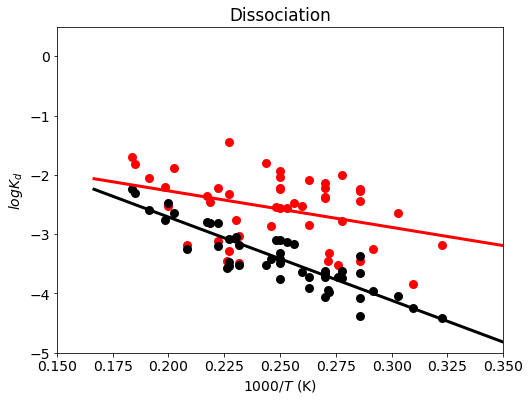

In [18]:
fig, ax2 = plt.subplots(figsize=(8,6))


ax2.set_xlim([0.15,0.35])
ax2.set_ylim([-5,0.5])
ax2.set_xlabel("$1000/T$ (K)")
ax2.set_ylabel("$log K_d$")
ax2.set_xlim([0.15,0.35])
ax2.set_title("Dissociation")
ax2.scatter(1000.0/df['T'], logKd_ds_ideal, lw=3, color="red"  , label="Data Dissoc (ideal)")
ax2.scatter(1000.0/df['T'], logKd_ds_ni   , lw=3, color="black", label="Data Disoc (non-ideal)")
ax2.plot(1000.0/Tcmb, fit_ds_ideal  , lw=3, color="black", label="fit ($K$)")
ax2.plot(1000.0/Tcmb, myfit_ds_ideal, lw=3, color="red"  , label="fit ($K_d$)")
#ax2.plot(1000.0/Tcmb, fit_ds      , lw=3, color="red"  , label="fit (ideal)")
ax.legend()

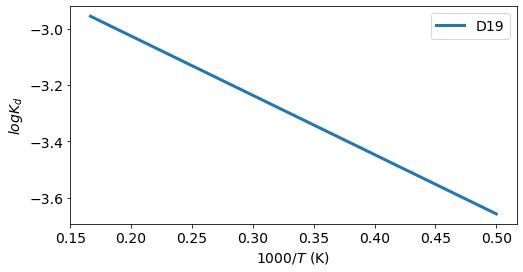

In [19]:
fig, ax1 = plt.subplots(figsize=(8,4))

fischer_a = plt.imread('Fischer_2016_fig6a.png')
fischer_b = plt.imread('Fischer_2016_fig6b.png')
#ax1.imshow(fischer_a, extent=(0.15,0.55,-5,2), aspect='auto') #Plot fischer plot below

#badro_1a = plt.imread('badro_18_fig1a.png')
#ax1.imshow(badro_1a, extent=(0.15,0.35,-3.5,-0.5), aspect='auto')

#ax1.set_ylim([-6,-1]) # Fischer Fig 6
ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$log K_d$")
#ax1.set_xlim([0.17,0.4])
#ax1.plot(1000.0/Tcmb, logKd_MgO_B16, lw=3, label="B16")
#ax1.plot(1000.0/Tcmb, logKd_MgO_O16, lw=3, label="O16")
ax1.plot(1000.0/Tcmb, logKd_MgO_D19_P8, lw=3, label="D19")
#ax1.plot(1000.0/Tcmb, fit_dl, lw=3, color="red"  , label="B18 (Dissolution)")
#ax1.plot(1000.0/Tcmb, fit_ds, lw=3, color="black", label="B18 (Dissociation)")
#ax1.plot(1000.0/Tcmb, logKd_MgO_B18E, label="E")
ax1.legend()